In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
import seaborn as sns
%matplotlib inline

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.utils import shuffle
import statsmodels.api as sm

In [17]:
# Load Dataset with all columns
# Making the data columns datetime objects with the parse_dates attribute
bikeshare_machine = pd.read_csv('/Users/matthewcassi/Documents/Bike-Sharing-Dataset/less_bikeshare_lat_lon.csv', 
                        parse_dates=['Start date', 'End date', 'start_date_short', 'end_date_short'])
# Removing the Unnamed column
bikeshare_machine.drop('Unnamed: 0', 1, inplace=True)

In [18]:
# creating a list of columns which will be used to create the list of columns to keep for the machine
# learning piece
list(bikeshare_machine.columns)

['Start date',
 'End date',
 'start_station',
 'start_station_code',
 'end_station',
 'end_station_code',
 'Member Type',
 'start_date_short',
 'end_date_short',
 'time_diff',
 'season',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'hum',
 'windspeed',
 'start_lat',
 'start_lon',
 'end_lat',
 'end_lon',
 'miles']

In [19]:
# Selecting the columns that are needed for the analysis
included_cols = ['Member Type',
                 'time_diff',
                 'season',
                 'mnth',
                 'holiday',
                 'weekday',
                 'workingday',
                 'weathersit',
                 'temp',
                 'hum',
                 'windspeed',
                 'miles']
# Subsetting the dataset so that only the columns above are included
bikeshare_machine = bikeshare_machine[included_cols]
bikeshare_machine.head()

,Member Type,time_diff,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,miles
0,Registered,1.833,2,3,0,4,1,3,0.268333,0.918333,0.217646,0.238743
1,Registered,3.317,2,3,0,4,1,3,0.268333,0.918333,0.217646,0.659533
2,Registered,5.733,2,3,0,4,1,3,0.268333,0.918333,0.217646,0.691996
3,Registered,8.700,2,3,0,4,1,3,0.268333,0.918333,0.217646,1.453796
4,Registered,7.850,2,3,0,4,1,3,0.268333,0.918333,0.217646,1.351053


In [20]:
# Make categorical data for columns like month, holiday, etc.
bikeshare_machine['season'] = bikeshare_machine['season'].astype('category')
bikeshare_machine['mnth'] = bikeshare_machine['mnth'].astype('category')
bikeshare_machine['holiday'] = bikeshare_machine['holiday'].astype('category')
bikeshare_machine['weekday'] = bikeshare_machine['weekday'].astype('category')
bikeshare_machine['workingday'] = bikeshare_machine['workingday'].astype('category')
bikeshare_machine['weathersit'] = bikeshare_machine['weathersit'].astype('category')
bikeshare_machine['Member Type'] = bikeshare_machine['Member Type'].astype('category')

In [21]:
# Update columns names for the dataset
col_names = ['member_type','time_diff','season','month','holiday',
             'weekday','work_day','weather_cat','temperature','humidity','windspeed','miles']
bikeshare_machine.columns = col_names

In [22]:
# Standardization of windspeed, humidity, and temperature were not all the same
# Values were changed back to their original values (not scaled)
tmin = -8
tmax = 39
hum_max = 100
wind_max = 67
bikeshare_machine['temp'] = bikeshare_machine['temperature'] * (tmax - tmin) + tmin
bikeshare_machine['hum'] = bikeshare_machine['humidity'] * 100
bikeshare_machine['wind'] = bikeshare_machine['windspeed'] * 67

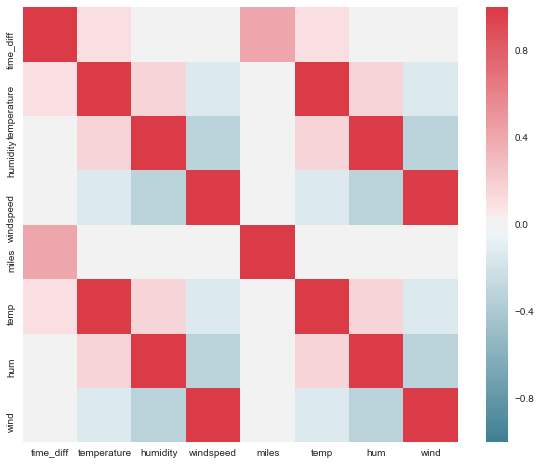

In [23]:
# Checking the correlations between continuous variables
corr = bikeshare_machine.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [24]:
# Turn categorical data into dummy variables. Dropping first dummy for the category variables that have 2 labels
bikeshare_machine = pd.get_dummies(bikeshare_machine, 
                                 columns=['member_type','holiday','work_day'], drop_first=True)
# Turning categorical data into dummy variables. Not dropping the first dummy for categorical data with more
# than 2 labels
bikeshare_machine = pd.get_dummies(bikeshare_machine, 
                                 columns=['season','month','weekday','weather_cat'])
bikeshare_machine.head()

,time_diff,temperature,humidity,windspeed,miles,temp,hum,wind,member_type_Registered,holiday_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_cat_1,weather_cat_2,weather_cat_3
0,1.833,0.268333,0.918333,0.217646,0.238743,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
1,3.317,0.268333,0.918333,0.217646,0.659533,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
2,5.733,0.268333,0.918333,0.217646,0.691996,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
3,8.700,0.268333,0.918333,0.217646,1.453796,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
4,7.850,0.268333,0.918333,0.217646,1.351053,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1


In [25]:
bikeshare_machine = shuffle(bikeshare_machine)
bikeshare_machine.head()

,time_diff,temperature,humidity,windspeed,miles,temp,hum,wind,member_type_Registered,holiday_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_cat_1,weather_cat_2,weather_cat_3
1147868,12.017,0.557500,0.579583,0.149883,0.361172,18.202500,57.9583,10.042161,1,0,...,0,0,0,0,1,0,0,1,0,0
974430,2.150,0.190000,0.522500,0.231358,0.322576,0.930000,52.2500,15.500986,1,1,...,0,1,0,0,0,0,0,1,0,0
169513,14.683,0.628333,0.688333,0.206471,1.554283,21.531651,68.8333,13.833557,1,0,...,0,0,0,0,1,0,0,0,1,0
1130570,5.050,0.466667,0.489167,0.207713,0.400570,13.933349,48.9167,13.916771,1,0,...,0,1,0,0,0,0,0,1,0,0
1167247,9.467,0.560833,0.807917,0.121271,1.608145,18.359151,80.7917,8.125157,1,0,...,0,0,1,0,0,0,0,1,0,0


### Lasso for Variables

In [30]:
X = bikeshare_machine.drop('time_diff', 1)
y = bikeshare_machine['time_diff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=17)

In [37]:
lasso = Lasso(fit_intercept=True)
alpha = np.arange(0.00001, 20, 25)
param_grid = {'alpha': alpha}
lasso_gs = GridSearchCV(lasso, param_grid, cv=5)
lasso_gs.fit(X_train, y_train)

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [41]:
coef = lasso_gs.best_estimator_.coef_
coef

array([  4.27940957e+00,  -2.66627775e-03,  -1.05498972e-02,
         6.32874658e+00,  -7.52306146e-03,  -5.19482047e-03,
        -2.29676505e-02,  -1.34634455e+01,  -5.07393511e-01,
        -1.37111650e+00,  -5.69803577e-02,   4.58002273e-02,
         1.25150575e-01,  -1.28688883e-01,   1.08698371e-02,
        -3.76279024e-02,   5.72901962e-01,   1.16256843e+00,
         8.11616805e-01,  -2.56058021e-01,  -6.92091413e-01,
        -3.97946459e-01,  -2.82120392e-01,   2.04368417e-01,
         2.41080216e-01,  -1.54941547e-01,   0.00000000e+00,
         6.92688722e-02,  -1.96000890e-01,  -2.33273391e-01,
        -1.25931410e-01,   7.46274158e-02,   1.39925285e-01,
         3.11498111e-01,   4.12584021e-03,  -6.42383692e-01])

In [45]:
column = X_train.columns
df = pd.DataFrame({'col': column, 'coef': coef})
small_df = df[df['coef'] != 0]
cols = list(small_df['col'])
cols

['temperature',
 'humidity',
 'windspeed',
 'miles',
 'temp',
 'hum',
 'wind',
 'member_type_Registered',
 'holiday_1',
 'work_day_1',
 'season_1',
 'season_2',
 'season_3',
 'season_4',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weather_cat_1',
 'weather_cat_2',
 'weather_cat_3']